# Assignment 1
This is a formal submission towards assignment 1 of UB Introduction to Reinforcement Learning. 

The notebook contains the following:
- [x] A gridworld with determinsitic environment
- [x] Gridworld with stochastic environment
- [x] Dynamic Programming for Policy Evaluation
- [x] Control method : Q-learning off-policy 


In [17]:
# Module level imports
import sys
sys.path.insert(0,'../')
import numpy as np
from collections import defaultdict
import pdb
np.random.seed()
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns
import pdb
#mpl.rcParams['figure.dpi']=300
%config InlineBackend.figure_format = 'svg'


import os
directory = '../Documents/UB/AssignmentOne'
if not os.path.exists(directory):
    os.makedirs(directory)

In [18]:
# Import codes from repository
from myenvs import gridworld
from solvers import dp, qlearning, utils


## Grid world
Let us look at the grid world we created:

We have two types of gridworld environments.
1. Deterministic :  That is for any state, taking an action leads to one single detrmined state by the environment
2. Stochastic :  For any given action at a state, there a probabrility of `p` you'll end up in a state `s'`

Now let us act randomly in the environment and check the basic steps. In the environment plot, there are two goals each noted as with a red color stop sign at the corners. Each step taken in given a `-1` reward and each terminal goals have a `0` reward.
The arrows show the direction of travel from any given state. Note that at the terminal any action is redundant.

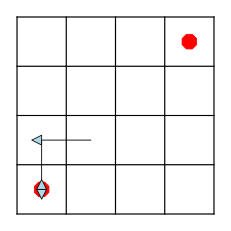

In [19]:
dgw = gridworld.DetermGridWorld(size=[4,4],plotgrid=False)

def random_policy(state):
    action = np.random.choice(np.arange(0,env.nA), 1)[0]
    return action
def optimal_policy(state):
    policy = [0, 3, 3, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0]
    action = policy[state]
    return action

def sample_from_env(env,policy, fname='figure'):
    env.reset(init_state = 5) # set init_state to None for random initialization
    is_done = False
    ax = plt.subplot(111)
    env._plotenv()
    while not is_done:
        action = optimal_policy(env.s)
        sp,r,is_done = env.step(action) # take the action
        env.render()
    plt.savefig(directory+'/'+ fname, dpi=500)
    plt.show()

sample_from_env(dgw, optimal_policy,fname='01-ExperienceOptimalPolicyDGW')


## Policy Evaluation
We can now use the tools from dynamic programming to evaluate our random policy.
We use two sets of methods : 
1. Uses iterative updates
2. Turning the updates into matrices

## Control Methods
We can obtain a policy using many control methods. Here we use `q-learning` approach to come up with a policy by just sampling from the environment and making updates to our `Q(s,a)` table.

In [20]:
from scipy.ndimage.filters import gaussian_filter1d

def plot_optimal_policy(Qsa,env,fname='figure'):
    """
    Given a Q(s,a) plots an optimal policy with in a gridworld environment.
    Optimal policy is determined by acting greedily with Q(s,a)
    """
    actions = env.actions
    optimal_policy = [10]*env.observation_space.n
    for state in range(env.observation_space.n):
        optimal_policy[state] = utils.greedy_policy(env,Qsa,state)
        
    ax = plt.subplot(111)
    env._plotenv()

    for ind,state in enumerate(env.flatgrid):
        ax.text(state[0],state[1],actions[optimal_policy[ind]])
    plt.title(r'$\pi^*$')
    plt.tight_layout()
    
    plt.savefig(directory+'/'+ fname, dpi=500)
    
    return optimal_policy

def _clean_figure(ax):
    ax.locator_params(axis='y', nbins=5)
    ax.locator_params(axis='x', nbins=5)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

def plot_learning_trace(opc, fname='figure',Sigma = 10):
    """
    Give a control policy class such as  MC-GLIE, SARSA or Q-learning,
    this function plots the following:
        1. Number of episodes vs Episode length -- Ideally should converge to the lowest
        2. Number of episodes vs Rewards -- Ideally should converge to the lowest possible
        3. Number of episodes vs Epsilon -- Should have a exponential decay behavior
        
    INPUTS:
    -------
        opc : Optimized Control Class 
    Outputs:
    --------
        Plots above mentioned plots as subplots 
    """
    fig = plt.figure(figsize=(12,4))
    ax = plt.subplot(1,3,1)
    ys = gaussian_filter1d(opc.trace.lengths, sigma=Sigma)
    ax.plot(np.arange(opc.num_episodes),ys)
    ax.set_ylabel('Episode length')
    _clean_figure(ax)
    
    ax = plt.subplot(1,3,2)
    ys = gaussian_filter1d(opc.trace.rewards, sigma=Sigma)
    ax.plot(np.arange(opc.num_episodes),opc.trace.rewards)
    ax.set_ylabel('Episode Rewards')
    _clean_figure(ax)
    
    ax = plt.subplot(1,3,3)
    ax.plot(np.arange(opc.num_episodes),opc.trace.epsilon)
    ax.set_ylabel(r'$\epsilon$')    
    _clean_figure(ax)
    
    fig.text(0.5, -0.04, 'Number of Episodes', ha='center', fontsize = 24)
    plt.subplots_adjust(wspace = 0.35)

    sns.despine()
    sns.set_context('paper')
    plt.tight_layout()
    
    plt.savefig(directory+'/'+ fname, dpi=500)

def plot_param_contour(env, fname='figure'):
    alpha = np.linspace(0.1,1.0,5)
    gamma = np.linspace(0.1,1.0,5)
    contourval = np.zeros((len(alpha),len(gamma)))
    for i,a in np.ndenumerate(alpha):
        for j,g in np.ndenumerate(gamma):
            ql = qlearning.Qlearning(env,num_episodes=200, verbose = False,\
                                     alpha = a, gamma = g)
            qsa = ql.tabular()
            contourval[i,j] = np.sum(ql.trace.lengths[-25:])/25
    fig, ax = plt.subplots(constrained_layout=True)
    cs = ax.contourf(alpha,gamma, contourval, cmap='bwr')
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel('Number of Episodes')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\gamma$')
    _clean_figure(ax)
    _clean_figure(cbar.ax)
    plt.savefig(directory+'/'+ fname, dpi=500)
    plt.show()

We need to set parameters `gamma` and `alpha` to run our selected Q-learning off-policy control policy. We try to get a suitable parameters by sweeping through the parameter space for a fixed 200 episodes and selecting a pair of parameters that have least number of average length of episodes for the last 25 episodes of the learning algorithm (i.e. at near convergence locations)

We can also try to play around with different `alpha` and `lambda` values that we had set to `1.0` by default. We can change those values and try to find a suitable `alpha` (for example).

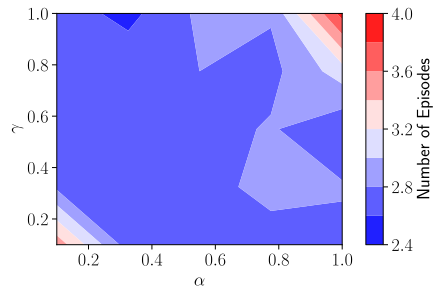

In [21]:
plot_param_contour(dgw,fname='DGWContourParams')

0/1000 episodes finished
100/1000 episodes finished
200/1000 episodes finished
300/1000 episodes finished
400/1000 episodes finished
500/1000 episodes finished
600/1000 episodes finished
700/1000 episodes finished
800/1000 episodes finished
900/1000 episodes finished


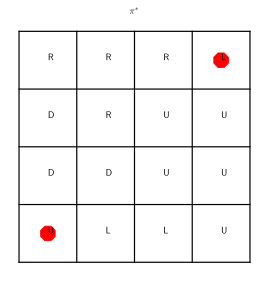

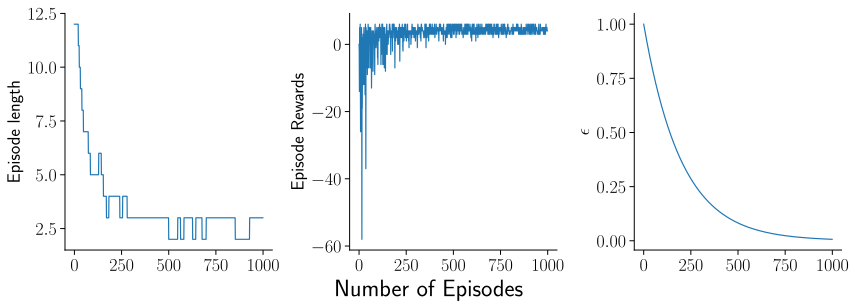

In [22]:
ql = qlearning.Qlearning(dgw,num_episodes=1000, verbose = True, gamma=0.6, alpha=0.5)
Q = ql.tabular()
OP = plot_optimal_policy(Q,dgw,fname='03-DGWQlearningOptimalPolicy')
plot_learning_trace(ql,fname='04-DGWQlearningTraces',Sigma=10)

## Stochastic Environment
In the previous environment we set the transition probabilities such that there's only one possible state the agent can end up, upon taking any given action. For example, an agent in the environment will have probability of `1.0` to end up on its `right` for action `right` and `0.0` for others. 

Here we have set the probabilities such that there's only `1/2` chance of ending up on its right and `1/6 th` of a chance of ending up in three other rectangular neighbouring states. Thus for any given action at a state, the agent is equally likely to end up any of the 4 rectangular states.

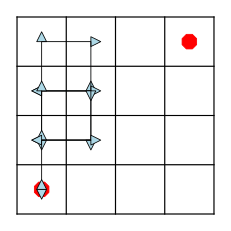

In [23]:
# take a run in the stochastic environment
sgw = gridworld.StochasticGridWorld(size=[4,4],plotgrid=False)
sample_from_env(sgw, optimal_policy,fname='06-SGWExpereinceOptimalPolicy')

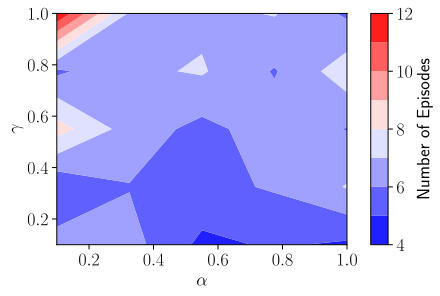

In [24]:
plot_param_contour(sgw,fname='SGWContourParams')

0/30000 episodes finished
3000/30000 episodes finished
6000/30000 episodes finished
9000/30000 episodes finished
12000/30000 episodes finished
15000/30000 episodes finished
18000/30000 episodes finished
21000/30000 episodes finished
24000/30000 episodes finished
27000/30000 episodes finished


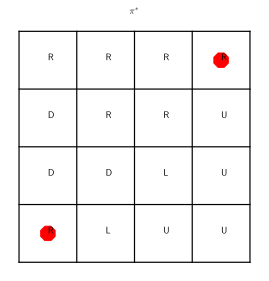

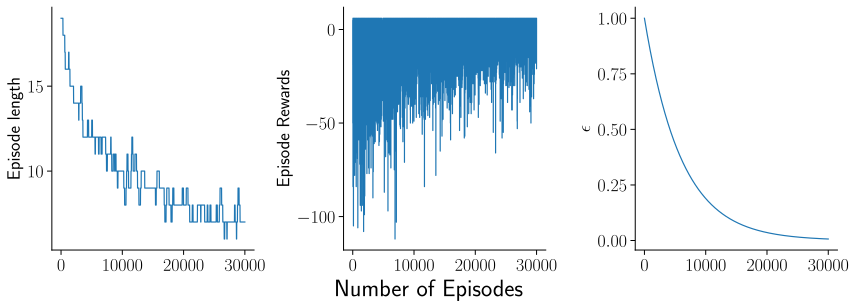

In [25]:
# Solve for optimal policy using Q-learning
N = 30000
ql = qlearning.Qlearning(sgw,num_episodes=N, verbose = True, eps_decay = 5/N,\
                         alpha = 0.5, gamma = 0.55)
Q = ql.tabular()
OP = plot_optimal_policy(Q,sgw,fname='08-SGWQlearningOptimalPolicy')
plot_learning_trace(ql,fname='09-SGWQlearningTrace',Sigma=100)

As can be seen, our control methods which are based on sampling from the environment are unable to converge. This is plainly due to stochasticity. Intuitively, because we bootstrap based on the experience, we tend to consider all the possible chances at a given state to be occuring with equal likelihood i.e. we tend to fit in a least square error solution while we should actually be building a maximum likelihood estimate of the environment. TD methods to some extent do that, and we test the below to see if we get any improvement.

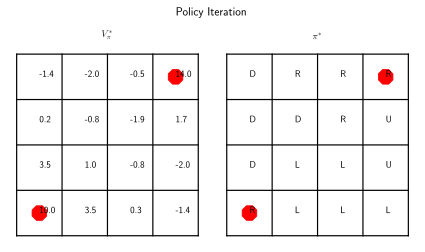

In [26]:
# Use DP to get an optimal policy
# Technically using DP is equivalent to using a maximum likelihood estimate of the environment so this might just work!
def plot_final_values(Pi,V, env):
    actions = env.actions
    plt.figure()
    ax1 = plt.subplot(121)
    env._plotenv()

    for ind,state in enumerate(env.flatgrid):
        ax1.text(state[0],state[1],'{0:.1f}'.format(V[ind][0]))
    plt.title(r'$V_{\pi}^*$')

    ax2 = plt.subplot(122)
    env._plotenv()

    for ind,state in enumerate(env.flatgrid):
        ax2.text(state[0],state[1],actions[Pi[ind]])
    plt.title(r'$\pi^*$')
    plt.tight_layout()

DP = dp.dp(sgw)
PiStar,VPiStar = DP.policy_iteration()
plot_final_values(PiStar,VPiStar, sgw)
plt.suptitle('Policy Iteration', fontsize=12)
plt.savefig(directory+'/'+ '10-SGWDPPolicyIteration', dpi=500)
plt.show()

And yes of course we do end up with an optimal policy. But note that DP expolits our known knowledge about stochasticty in the environemnt which may not be available all the time. 
 